In [1]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

Number of Training Images Before Augmentation:
Parasitized: 13780
Uninfected: 13780

Number of Testing Images Before Augmentation:
Parasitized: 7952
Uninfected: 7880


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


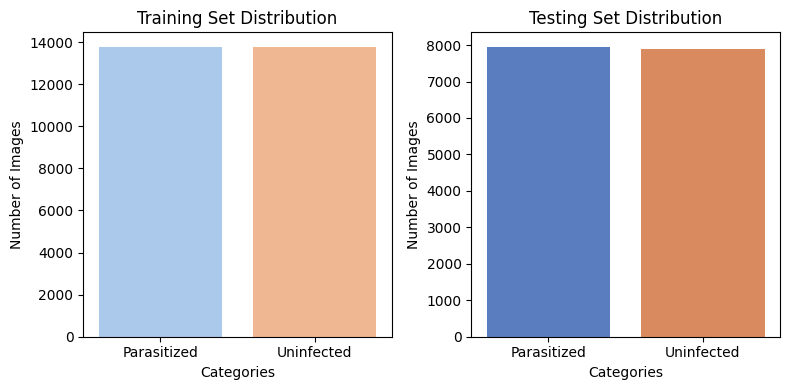

Sample Image Shape (Before Augmentation): (151, 130, 3)


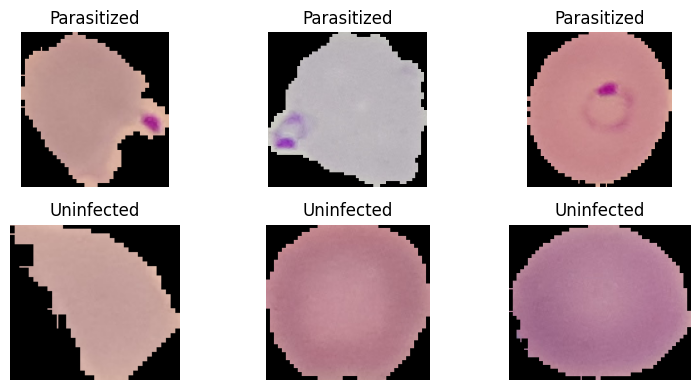

In [3]:
# Define paths
my_data_dir = '../input/files1/Malaria Cells'
train_path = my_data_dir + '/training_set'
test_path = my_data_dir + '/testing_set'

# Dataset Distribution Visualization
categories = ['Parasitized', 'Uninfected']
train_counts = [len(os.listdir(os.path.join(train_path, cat))) for cat in categories]
test_counts = [len(os.listdir(os.path.join(test_path, cat))) for cat in categories]

print("Number of Training Images Before Augmentation:")
for category, count in zip(categories, train_counts):
    print(f"{category}: {count}")

print("\nNumber of Testing Images Before Augmentation:")
for category, count in zip(categories, test_counts):
    print(f"{category}: {count}")

# Plot train and test distribution
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
sns.barplot(x=categories, y=train_counts, palette='pastel')
plt.title("Training Set Distribution")
plt.ylabel("Number of Images")
plt.xlabel("Categories")

plt.subplot(1, 2, 2)
sns.barplot(x=categories, y=test_counts, palette='muted')
plt.title("Testing Set Distribution")
plt.ylabel("Number of Images")
plt.xlabel("Categories")

plt.tight_layout()
plt.show()

# Image shape before augmentation
sample_image_path = os.path.join(train_path, 'Parasitized', os.listdir(os.path.join(train_path, 'Parasitized'))[0])
sample_image = imread(sample_image_path)
print("Sample Image Shape (Before Augmentation):", sample_image.shape)

# Display 6 samples from the original dataset (before augmentation)
def display_sample_images(image_dir, categories, num_samples=6):
    plt.figure(figsize=(8, 4))
    for i, category in enumerate(categories):
        # Get the list of images in the category
        image_paths = os.listdir(os.path.join(image_dir, category))
        # Randomly select image paths
        sample_paths = np.random.choice(image_paths, num_samples // len(categories), replace=True)    
        for j, image_path in enumerate(sample_paths):
            img = imread(os.path.join(image_dir, category, image_path))
            plt.subplot(len(categories), num_samples // len(categories), i * (num_samples // len(categories)) + j + 1)
            plt.imshow(img)
            plt.axis('off')
            plt.title(f"{category}")
    plt.tight_layout()
    plt.show()

# Display 6 samples
display_sample_images(train_path, categories)

In [4]:
# Data Augmentation
image_shape = (224, 224, 3)
batch_size = 32

train_datagen = ImageDataGenerator(rescale=1/255)

test_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=image_shape[:2],
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=image_shape[:2],
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

Found 27558 images belonging to 2 classes.
Found 15832 images belonging to 2 classes.


In [5]:
# Calculate Class Weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))

# Load and Fine-Tune EfficientNetB0
base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=image_shape)

# Fine-tune by unfreezing the last 120 layers
for layer in base_model.layers[-120:]:
    layer.trainable = True

# Build Model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.008)),
    Dropout(0.4),  # Adjusted dropout to avoid overfitting
    Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.008)),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Binary classification
])
# Force building the model to ensure the summary is correct
model.build(input_shape=(None,) + image_shape)
# Display the model summary
print("Model Summary:")
base_model.summary()
model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Model Summary:


Model: "efficientnetb0"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 224, 224, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 224, 224, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 32)   │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 32)   │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 32)   │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 32)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand    

 Total params: 4,049,571 (15.45 MB)

 Trainable params: 4,007,548 (15.29 MB)

 Non-trainable params: 42,023 (164.16 KB)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,221,860 (16.11 MB)

 Trainable params: 4,179,837 (15.94 MB)

 Non-trainable params: 42,023 (164.16 KB)

Epoch 1/52


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


862/862 ━━━━━━━━━━━━━━━━━━━━ 313s 274ms/step - accuracy: 0.7143 - loss: 3.0052 - val_accuracy: 0.9464 - val_loss: 2.4383 - learning_rate: 1.0000e-05
Epoch 2/52
862/862 ━━━━━━━━━━━━━━━━━━━━ 153s 177ms/step - accuracy: 0.9551 - loss: 2.3230 - val_accuracy: 0.9605 - val_loss: 2.0356 - learning_rate: 1.0000e-05
Epoch 3/52
862/862 ━━━━━━━━━━━━━━━━━━━━ 150s 173ms/step - accuracy: 0.9601 - loss: 1.9740 - val_accuracy: 0.9633 - val_loss: 1.7063 - learning_rate: 1.0000e-05
Epoch 4/52
862/862 ━━━━━━━━━━━━━━━━━━━━ 153s 177ms/step - accuracy: 0.9647 - loss: 1.6490 - val_accuracy: 0.9666 - val_loss: 1.4095 - learning_rate: 1.0000e-05
Epoch 5/52
862/862 ━━━━━━━━━━━━━━━━━━━━ 150s 173ms/step - accuracy: 0.9648 - loss: 1.3623 - val_accuracy: 0.9708 - val_loss: 1.1515 - learning_rate: 1.0000e-05
Epoch 6/52
862/862 ━━━━━━━━━━━━━━━━━━━━ 150s 174ms/step - accuracy: 0.9680 - loss: 1.1125 - val_accuracy: 0.9751 - val_loss: 0.9336 - learning_rate: 1.0000e-05
Epoch 7/52
862/862 ━━━━━━━━━━━━━━━━━━━━ 150s 174ms/

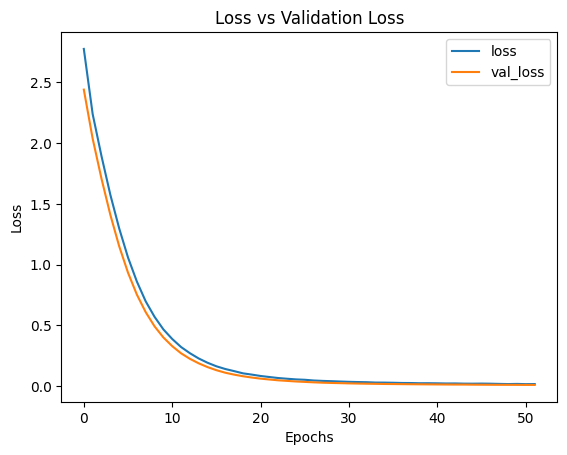

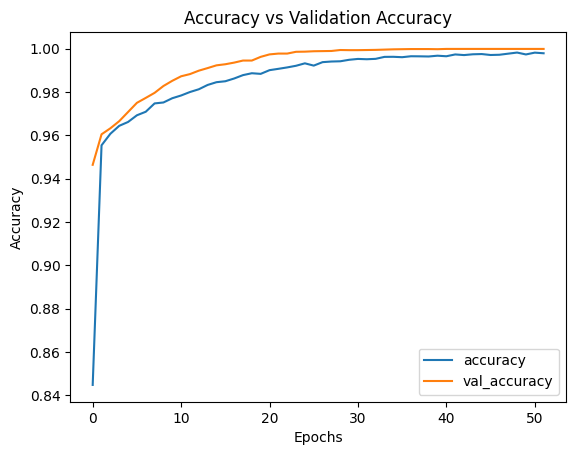

In [6]:
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),  # Slightly lower LR for fine-tuning
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)
model_checkpoint = ModelCheckpoint(
    filepath='my_model.keras',
    monitor='val_loss',
    save_best_only=True,
    mode='min'
)

# Train the model
history = model.fit(
    train_generator,
    epochs=52,
    validation_data=test_generator,
    callbacks=[early_stop, lr_reduce, model_checkpoint],  # Added ModelCheckpoint
    class_weight=class_weights  
)
model.save('my_model.keras')
# Plot training and validation loss
losses = pd.DataFrame(history.history)
losses[['loss', 'val_loss']].plot(title='Loss vs Validation Loss', ylabel='Loss', xlabel='Epochs')

# Plot training and validation accuracy
losses[['accuracy', 'val_accuracy']].plot(title='Accuracy vs Validation Accuracy', ylabel='Accuracy', xlabel='Epochs')
# Evaluate the model
results = model.evaluate(test_generator)
test_loss = results[0]
test_accuracy = results[1]
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

495/495 ━━━━━━━━━━━━━━━━━━━━ 31s 62ms/step
Classification Report for EfficientNetB0:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7952
           1       1.00      1.00      1.00      7880

    accuracy                           1.00     15832
   macro avg       1.00      1.00      1.00     15832
weighted avg       1.00      1.00      1.00     15832

Confusion Matrix:


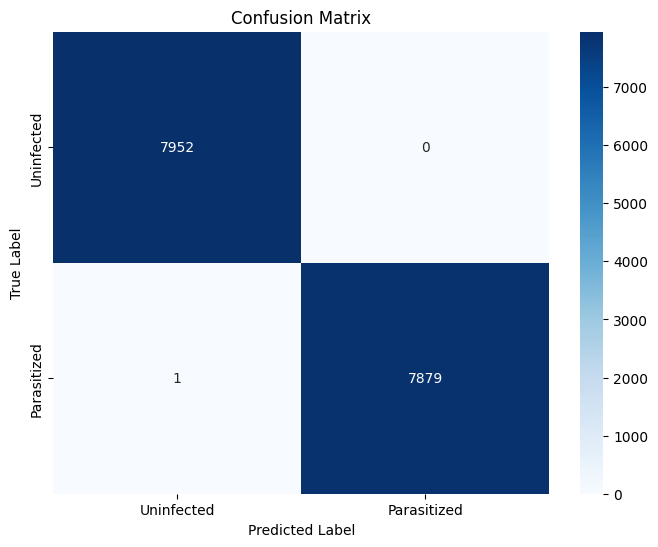

In [9]:
# Predictions and Evaluation
pred_probabilities = model.predict(test_generator)
predictions = (pred_probabilities > 0.5).astype(int)

# Classification Report and Confusion Matrix
from sklearn.metrics import classification_report, confusion_matrix

print("Classification Report for EfficientNetB0:")
print(classification_report(test_generator.classes, predictions))

# Confusion Matrix
cm = confusion_matrix(test_generator.classes, predictions)
print("Confusion Matrix:")
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Uninfected', 'Parasitized'], yticklabels=['Uninfected', 'Parasitized'])
plt.title("Confusion Matrix")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()